In [15]:
# [作業目標]
# 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
# 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
# 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
# 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [16]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = './data/'

In [17]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [18]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)



In [20]:
# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
birth = np.round(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365)

In [21]:
equal_width_birth = pd.cut(birth, 6)
equal_width_birth.value_counts()


(37.0, 45.0]      61625
(29.0, 37.0]      57671
(45.0, 53.0]      51215
(53.0, 61.0]      50460
(20.952, 29.0]    36385
(61.0, 69.0]      25330
Name: DAYS_BIRTH, dtype: int64

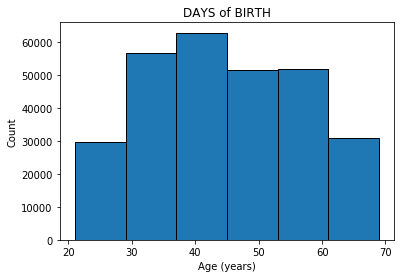

In [22]:
plt.hist(birth, edgecolor = 'k', bins = 6)
plt.title('DAYS of BIRTH'); plt.xlabel('Age (years)'); plt.ylabel('Count');
plt.show()

In [23]:
equal_freq_birth = pd.qcut(birth, 6)
ser, birth_qbins = pd.qcut(birth, 6, retbins=True, labels=False)
birth_qbins

array([21., 31., 38., 43., 51., 58., 69.])

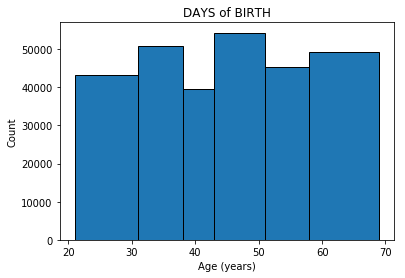

In [24]:
plt.hist(birth, edgecolor = 'k', bins = birth_qbins)
plt.title('DAYS of BIRTH'); plt.xlabel('Age (years)'); plt.ylabel('Count');
plt.show()

In [25]:
# 官方解答

# 先來看看 'DAYS_BIRTH' 的統計描述吧 (pandas.describe())
print("Correlation between TARGET and DAYS_BIRTH", app_train['DAYS_BIRTH'].corr(app_train['TARGET']))
(app_train['DAYS_BIRTH']/365).describe()


Correlation between TARGET and DAYS_BIRTH -0.07823930830982712


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [29]:
# 雖然由之前的分析發現 DAYS_BIRTH 與 TARGET 的相關係數只有 -0.07，但直覺上這個變數應該會提供模型不少訊息

# 將年齡相關資料, 另外存成一個 DataFrame 來處理
# age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data = app_train.loc[:, ['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# 將年齡資料離散化 / 分組
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [30]:
# 依照組別彙整年齡資料 "每一欄的平均值"
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


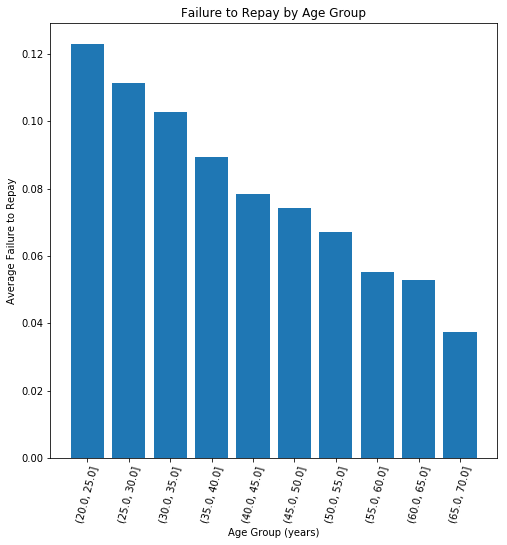

In [31]:
plt.figure(figsize = (8, 8))

# 繪製目標值平均與分組組別的長條圖
plt.bar(range(len(age_groups.index)), age_groups['TARGET'])
# 加上 X, y 座標說明, 以及圖表的標題
plt.xticks(range(len(age_groups.index)), age_groups.index, rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Average Failure to Repay')
plt.title('Failure to Repay by Age Group');

In [ ]:
# 可以非常明顯地看出趨勢，越年輕的客戶族群的違約遲繳的可能越大！